<a href="https://colab.research.google.com/github/alecbidaran/Deep-learning/blob/main/kinetics_400.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf 
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras as keras 
import numpy as np 
import matplotlib.pyplot as plt
import functools
from imutils import paths
import os 
import cv2 


In [ ]:
!unrar x '/content/drive/My Drive/datasets/kinetics-400/RGB.rar'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/My Drive/datasets/kinetics-400/RGB.rar

Creating    RGB                                                       OK
Creating    RGB/Arm                                                   OK
Extracting  RGB/Arm/1 Arm cable row to rotation5.jpg                       0%  OK 
Extracting  RGB/Arm/1 Arm cable row to rotation6.jpg                       0%  OK 
Extracting  RGB/Arm/1 Arm cable row to rotation7.jpg                       0%  OK 
Extracting  RGB/Arm/Arm Openings for thoracic rotation with Viva Physio10.jpg       0%  OK 
Extracting  RGB/Arm/Arm Openings for thoracic rotation with Viva Physio11.jpg       0%  OK 
Extracting  RGB/Arm/Arm Openings for thoracic rotation with Viva Physio12.jpg       0%  OK 
Extracting  RGB/Arm/Arm Openings for thoracic rotation with Viva Physio13.jpg       0%  OK 
Extracting  RGB/Arm/Arm Openings f

In [ ]:
RGB_train='/content/RGB'


In [ ]:
train_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=0.2,horizontal_flip=True,validation_split=0.2)
test_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True,validation_split=0.2)
test1_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True)

In [ ]:
train_RGB_batch=train_datagen.flow_from_directory(RGB_train,target_size=(224,224),color_mode='rgb', classes=None, class_mode='categorical', batch_size=16, shuffle=True,subset='training')
test_RGB_batch=test_datagen.flow_from_directory(RGB_train,target_size=(224,224),color_mode='rgb',classes=None, class_mode='categorical',batch_size=16,shuffle=True,subset='validation')
#test_RGB_batch=test_datagen.flow_from_directory(RGB_test,target_size=(224,224),batch_size=8,shuffle=True)


Found 3367 images belonging to 9 classes.
Found 837 images belonging to 9 classes.


In [ ]:
mobile_net_backend=keras.applications.MobileNet(input_shape=(224,224,3),weights='imagenet',include_top=False)
resnet50_backend=keras.applications.ResNet50(input_shape=(256,256,3),weights='imagenet',include_top=False)

In [ ]:
mobile_net_backend.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [ ]:
def create_model():
  flatten=keras.layers.Flatten()(mobile_net_backend.output)
  Dense1=keras.layers.Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5,l2=1e-4))(flatten)
  dropout=keras.layers.Dropout(0.5)(Dense1)
  classification=keras.layers.Dense(9,activation="softmax",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5,l2=1e-4))(dropout)
  model=keras.models.Model(inputs=mobile_net_backend.inputs,outputs=classification)
  return model

In [ ]:
for layer in mobile_net_backend.layers[:86]:
    layer.trainable=False


In [ ]:
for i,layer in enumerate( mobile_net_backend.layers):
  print(i,layer.name,layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1 False
3 conv1_bn False
4 conv1_relu False
5 conv_dw_1 False
6 conv_dw_1_bn False
7 conv_dw_1_relu False
8 conv_pw_1 False
9 conv_pw_1_bn False
10 conv_pw_1_relu False
11 conv_pad_2 False
12 conv_dw_2 False
13 conv_dw_2_bn False
14 conv_dw_2_relu False
15 conv_pw_2 False
16 conv_pw_2_bn False
17 conv_pw_2_relu False
18 conv_dw_3 False
19 conv_dw_3_bn False
20 conv_dw_3_relu False
21 conv_pw_3 False
22 conv_pw_3_bn False
23 conv_pw_3_relu False
24 conv_pad_4 False
25 conv_dw_4 False
26 conv_dw_4_bn False
27 conv_dw_4_relu False
28 conv_pw_4 False
29 conv_pw_4_bn False
30 conv_pw_4_relu False
31 conv_dw_5 False
32 conv_dw_5_bn False
33 conv_dw_5_relu False
34 conv_pw_5 False
35 conv_pw_5_bn False
36 conv_pw_5_relu False
37 conv_pad_6 False
38 conv_dw_6 False
39 conv_dw_6_bn False
40 conv_dw_6_relu False
41 conv_pw_6 False
42 conv_pw_6_bn False
43 conv_pw_6_relu False
44 conv_dw_7 False
45 conv_dw_7_bn False
46 conv_dw_7_relu False
47 conv_pw_7 Fal

In [ ]:
def scheduler(epoch, lr):
  if epoch<10:
    return lr 
  else:
    return lr*tf.math.exp(-0.1)

In [ ]:
keras.backend.clear_session()
top5acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=5)
top5acc.__name__="top5acc"
top1acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=1)
top1acc.__name__="top1acc"
model=create_model()
lr_sched=keras.optimizers.schedules.ExponentialDecay(1e-2,decay_steps=1000,decay_rate=1e-4)
model.compile(optimizer=keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=False),loss='categorical_crossentropy',metrics=[top5acc,top1acc])
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [ ]:
sched = tf.keras.callbacks.LearningRateScheduler(scheduler)
checkpoint=keras.callbacks.ModelCheckpoint(
        filepath='finetune_mobilenet_RGB.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
earlystopping=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
reduced=keras.callbacks.ReduceLROnPlateau()
callbacks=[checkpoint,reduced,sched]

In [ ]:
history=model.fit_generator(train_RGB_batch,steps_per_epoch=300,validation_data=test_RGB_batch,validation_steps=100,epochs=30,verbose=1,callbacks=callbacks,workers=16)

Epoch 1/30
300/300 [==============================] - 64s 213ms/step - loss: 4.2615 - top5acc: 0.9588 - top1acc: 0.7583 - val_loss: 4.7196 - val_top5acc: 0.9081 - val_top1acc: 0.5809
Epoch 2/30
300/300 [==============================] - 61s 205ms/step - loss: 3.1457 - top5acc: 0.9981 - top1acc: 0.9455 - val_loss: 4.7531 - val_top5acc: 0.9377 - val_top1acc: 0.6167
Epoch 3/30
300/300 [==============================] - 63s 211ms/step - loss: 3.0629 - top5acc: 0.9994 - top1acc: 0.9710 - val_loss: 5.4302 - val_top5acc: 0.8955 - val_top1acc: 0.5544
Epoch 4/30
300/300 [==============================] - 62s 208ms/step - loss: 3.0143 - top5acc: 1.0000 - top1acc: 0.9820 - val_loss: 5.3381 - val_top5acc: 0.9213 - val_top1acc: 0.5639
Epoch 5/30
300/300 [==============================] - 63s 210ms/step - loss: 2.9737 - top5acc: 1.0000 - top1acc: 0.9887 - val_loss: 5.2240 - val_top5acc: 0.9031 - val_top1acc: 0.5916
Epoch 6/30
300/300 [==============================] - 62s 208ms/step - loss: 2.9570 -

Text(0, 0.5, 'percent')

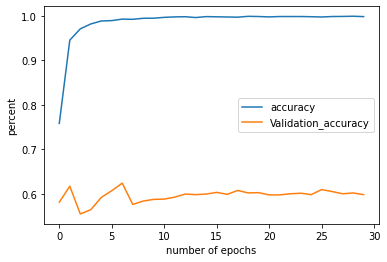

In [ ]:
plt.plot(history.history["top1acc"],label="accuracy")
plt.plot(history.history["val_top1acc"],label="Validation_accuracy")
plt.legend()
plt.xlabel("number of epochs")
plt.ylabel("percent")

Text(0, 0.5, 'percent')

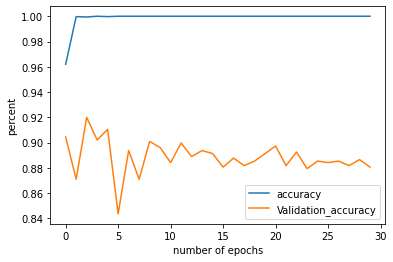

In [ ]:
plt.plot(history.history["top5acc"],label="accuracy")
plt.plot(history.history["val_top5acc"],label="Validation_accuracy")
plt.legend()
plt.xlabel("number of epochs")
plt.ylabel("percent")

In [ ]:
model.save("augfitness_RGB30.h5")

Text(0, 0.5, 'percent')

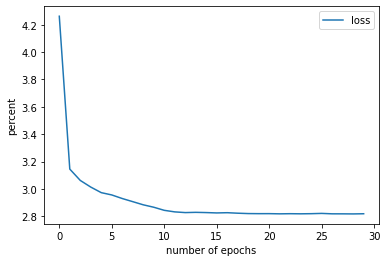

In [ ]:
plt.plot(history.history["loss"],label="loss")
plt.legend()
plt.xlabel("number of epochs")
plt.ylabel("percent")

In [ ]:
test1_RGB_batch=test_datagen.flow_from_directory(RGB_train,target_size=(224,224),color_mode='rgb',classes=None, class_mode='categorical',batch_size=16,shuffle=False,subset='validation')


Found 837 images belonging to 9 classes.


In [ ]:
model.evaluate_generator(test1_RGB_batch,steps=40)

[4.9794769287109375, 0.9750000238418579, 0.645312488079071]

In [ ]:
best_model=create_model()
best_model.load_weights("/content/aughomefitness_RGB30.h5")

In [ ]:
best_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=False),loss='categorical_crossentropy',metrics=[top5acc,top1acc])
best_model.evaluate_generator(valid_RGB_batch)

[8.331304550170898, 0.9468713402748108, 0.5623770356178284]

In [ ]:
imagenet_model=create_model()
imagenet_model.load_weights("/content/imagenet_mobilenet_rgb.03-9.76.h5")

In [ ]:
fine_tune=create_model()
fine_tune.load_weights("/content/finetune_mobilenet_rgb.03-3.18.h5")

In [ ]:
model.evaluate(test_RGB_batch)

60/60 [==============================] - 8s 126ms/step - loss: 0.1529 - top5acc: 0.9963 - top1acc: 0.9584


[0.15287569165229797, 0.9963119029998779, 0.9583772420883179]

In [ ]:
imagenet_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001,momentum=0.9),loss='categorical_crossentropy',metrics=[top5acc,top1acc])
imagenet_model.evaluate(test_RGB_batch)

65/65 [==============================] - 13s 199ms/step - loss: 9.7551 - top5acc: 0.7824 - top1acc: 0.3473


[9.755133628845215, 0.7824186682701111, 0.3472559452056885]

In [ ]:
fine_tune.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001,momentum=0.9),loss='categorical_crossentropy',metrics=[top5acc,top1acc])
fine_tune.evaluate(test_RGB_batch,workers=8)

258/258 [==============================] - 150s 580ms/step - loss: 3.1842 - top5acc: 0.8810 - top1acc: 0.5605


[3.18418550491333, 0.8810101747512817, 0.5604662299156189]

In [ ]:
pred=best_model.predict(test_RGB_batch)

In [ ]:
pred=fine_tune.predict(test_RGB_batch)

In [ ]:
pred=model.predict(test_flow_batch)

In [ ]:
pred

array([[8.91605366e-12, 1.51665085e-12, 1.47546309e-12, ...,
        2.73634820e-13, 1.33014563e-12, 1.34233586e-12],
       [1.02655315e-08, 2.77773253e-08, 4.16088333e-05, ...,
        4.43326194e-08, 1.11601516e-07, 1.61368541e-09],
       [3.82093452e-02, 8.42951692e-07, 9.54311848e-01, ...,
        1.79530213e-09, 1.61812684e-04, 8.35044034e-07],
       ...,
       [2.24179780e-06, 1.62298425e-10, 2.09422772e-08, ...,
        5.56613748e-11, 4.51561135e-07, 9.99994040e-01],
       [1.91715822e-06, 3.19422035e-08, 7.18807598e-07, ...,
        4.96076780e-07, 2.01604844e-09, 7.70410188e-05],
       [1.16019864e-05, 1.18789700e-10, 1.14440777e-08, ...,
        6.95691726e-09, 6.85111093e-13, 1.92231422e-08]], dtype=float32)

# Flow 

In [ ]:
!unrar x '/content/drive/My Drive/datasets/kinetics-400/Flow.rar'

Streaming output truncated to the last 5000 lines.
Extracting  images/Arm/Single Arm Towel Row With Rotation15.jpg            5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation16.jpg            5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation17.jpg            5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation18.jpg            5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation19.jpg            5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation6.jpg             5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation8.jpg             5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation9.jpg             5%  OK 
Extracting  images/Arm/Single Arm Trunk Rotation with Cable10.jpg          5%  OK 
Extracting  images/Arm/Single Arm Trunk Rotation with Cable11.jpg          5%  OK 
Extracting  images/Arm/Single

In [ ]:
Denisty_dir='/content/images'

In [ ]:
train_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=0.2,horizontal_flip=True,validation_split=0.2)
test_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True,validation_split=0.2)
test1_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True)

In [ ]:
train_Dense_batch=train_datagen.flow_from_directory(Denisty_dir,target_size=(224,224),color_mode='rgb', classes=None, class_mode='categorical', batch_size=16, shuffle=True,subset='training')
test_Dense_batch=test_datagen.flow_from_directory(Denisty_dir,target_size=(224,224),color_mode='rgb',classes=None, class_mode='categorical',batch_size=16,shuffle=False,subset='validation')
#test_RGB_batch=test_datagen.flow_from_directory(RGB_test,target_size=(224,224),batch_size=8,shuffle=True)


Found 4326 images belonging to 9 classes.
Found 1075 images belonging to 9 classes.


In [ ]:
mobile_net_backend=keras.applications.MobileNet(input_shape=(224,224,3),weights='imagenet',include_top=False)


In [ ]:
def create_model():
  flatten=keras.layers.Flatten()(mobile_net_backend.output)
  Dense1=keras.layers.Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5,l2=1e-4))(flatten)
  dropout=keras.layers.Dropout(0.5)(Dense1)
  classification=keras.layers.Dense(9,activation="softmax",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5,l2=1e-4))(dropout)
  model=keras.models.Model(inputs=mobile_net_backend.inputs,outputs=classification)
  return model

In [ ]:
for layer in mobile_net_backend.layers[:83]:
    layer.trainable=False


In [ ]:
keras.backend.clear_session()
top5acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=5)
top5acc.__name__="top5acc"
top1acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=1)
top1acc.__name__="top1acc"
model=create_model()
lr_sched=keras.optimizers.schedules.ExponentialDecay(1e-2,decay_steps=1000,decay_rate=1e-4)
model.compile(optimizer=keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=False),loss='categorical_crossentropy',metrics=[top5acc,top1acc])
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [ ]:
def scheduler(epoch, lr):
  if epoch<10:
    return lr 
  else:
    return lr*tf.math.exp(-0.1)

In [ ]:
sched = tf.keras.callbacks.LearningRateScheduler(scheduler)
checkpoint=keras.callbacks.ModelCheckpoint(
        filepath='finetune_mobilenet_flow.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
earlystopping=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
reduced=keras.callbacks.ReduceLROnPlateau()
callbacks=[checkpoint,reduced,sched]

In [ ]:
history=model.fit_generator(train_Dense_batch,steps_per_epoch=1000,validation_data=test_Dense_batch,epochs=30,verbose=1,callbacks=callbacks,workers=16)

Epoch 1/30
1000/1000 [==============================] - 179s 179ms/step - loss: 4.5117 - top5acc: 0.9073 - top1acc: 0.5346 - val_loss: 5.4525 - val_top5acc: 0.7516 - val_top1acc: 0.3433
Epoch 2/30
1000/1000 [==============================] - 179s 179ms/step - loss: 3.6461 - top5acc: 0.9764 - top1acc: 0.7671 - val_loss: 5.4365 - val_top5acc: 0.8158 - val_top1acc: 0.3200
Epoch 3/30
1000/1000 [==============================] - 177s 177ms/step - loss: 3.3354 - top5acc: 0.9902 - top1acc: 0.8562 - val_loss: 5.6398 - val_top5acc: 0.8270 - val_top1acc: 0.3684
Epoch 4/30
1000/1000 [==============================] - 178s 178ms/step - loss: 3.1767 - top5acc: 0.9938 - top1acc: 0.8974 - val_loss: 5.9086 - val_top5acc: 0.8102 - val_top1acc: 0.3507
Epoch 5/30
1000/1000 [==============================] - 177s 177ms/step - loss: 3.0603 - top5acc: 0.9957 - top1acc: 0.9212 - val_loss: 5.9245 - val_top5acc: 0.8372 - val_top1acc: 0.3386
Epoch 6/30
1000/1000 [==============================] - 177s 177ms/ste

Text(0, 0.5, 'percent')

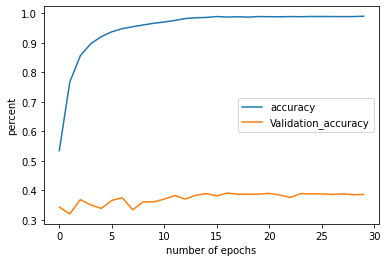

In [ ]:
plt.plot(history.history["top1acc"],label="accuracy")
plt.plot(history.history["val_top1acc"],label="Validation_accuracy")
plt.legend()
plt.xlabel("number of epochs")
plt.ylabel("percent")

Text(0, 0.5, 'percent')

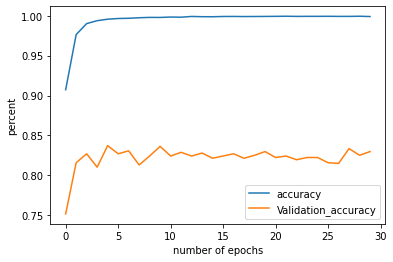

In [ ]:
plt.plot(history.history["top5acc"],label="accuracy")
plt.plot(history.history["val_top5acc"],label="Validation_accuracy")
plt.legend()
plt.xlabel("number of epochs")
plt.ylabel("percent")

In [ ]:
model.evaluate_generator(test_Dense_batch)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[6.31369161605835, 0.820465087890625, 0.3869767487049103]

In [ ]:
model.save('kinetics_FLow_mobilenet.h5')

In [ ]:
!cp "/content/kinetics_FLow_mobilenet.h5" "/content/drive/My Drive/nets"

# Conv3D


In [ ]:
image_paths=list(paths.list_images(Denisty_dir))

In [ ]:
data=[]
Label=[]
print("[INFO] loading images...")
for image_path in image_paths:
  label=image_path.split(os.path.sep)[-2]
  image=cv2.imread(image_path)
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(224,224))
  data.append(image)
  Label.append(label)
  
  

[INFO] loading images...


In [ ]:
Image=np.array(data,dtype=np.float32)
Label=np.array(Label)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

lb=LabelBinarizer()
Labelb=lb.fit_transform(Label)

In [ ]:
Image=Image.reshape((-1,1,224,224,3))

In [ ]:
train_x,test_x,train_y,test_y=train_test_split(Image,Labelb,test_size=0.5,random_state=3)

In [ ]:
train_y.shape

(1122, 10)

In [ ]:
tf.random.set_seed(0)
con3d_model=keras.models.Sequential([
                                     keras.layers.Input(shape=(1,224,224,3)),
                                     keras.layers.Conv3D(16,kernel_size=(3,3,3),activation='relu',padding="same"),
                                    keras.layers.Conv3D(32,kernel_size=(3,3,3),activation='relu',padding="same"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Flatten(),
                                     #keras.layers.Dropout(0.4),
                                     #keras.layers.Dense(512,activation='relu'),
                                    keras.layers.Dropout(0.4),
                                     keras.layers.Dense(10,activation='softmax')

])

In [ ]:
con3d_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 1, 224, 224, 16)   1312      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 224, 224, 32)   13856     
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 224, 224, 32)   128       
_________________________________________________________________
flatten (Flatten)            (None, 1605632)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1605632)           0         
_________________________________________________________________
dense (Dense)                (None, 10)                16056330  
Total params: 16,071,626
Trainable params: 16,071,562
Non-trainable params: 64
___________________________________________

In [ ]:
keras.backend.clear_session()
top5acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=5)
top5acc.__name__="top5acc"
top1acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=1)
top1acc.__name__="top1acc"
lr_sched=keras.optimizers.schedules.ExponentialDecay(0.001,decay_steps=200,decay_rate=1e-4)
con3d_model.compile(optimizer=keras.optimizers.SGD(1e-4,momentum=0.9,nesterov=False,decay=1e-4/20),loss='categorical_crossentropy',metrics=[top5acc,top1acc])


In [ ]:
checkpoint=keras.callbacks.ModelCheckpoint(
        filepath='3dconv_flow.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
earlystopping=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
reduced=keras.callbacks.ReduceLROnPlateau()
callbacks=[checkpoint,reduced]

In [ ]:
history=con3d_model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=8,batch_size=2,verbose=1,callbacks=callbacks)

Epoch 1/8
561/561 [==============================] - 14s 25ms/step - loss: 5.6285 - top5acc: 0.8289 - top1acc: 0.5383 - val_loss: 0.7251 - val_top5acc: 0.9662 - val_top1acc: 0.7952
Epoch 2/8
561/561 [==============================] - 14s 25ms/step - loss: 0.1145 - top5acc: 0.9964 - top1acc: 0.9688 - val_loss: 0.5767 - val_top5acc: 0.9733 - val_top1acc: 0.8495
Epoch 3/8
561/561 [==============================] - 14s 25ms/step - loss: 0.0409 - top5acc: 0.9964 - top1acc: 0.9866 - val_loss: 0.5711 - val_top5acc: 0.9786 - val_top1acc: 0.8664
Epoch 4/8
561/561 [==============================] - 14s 25ms/step - loss: 0.0332 - top5acc: 0.9991 - top1acc: 0.9866 - val_loss: 0.5497 - val_top5acc: 0.9742 - val_top1acc: 0.8682
Epoch 5/8
561/561 [==============================] - 14s 24ms/step - loss: 0.0323 - top5acc: 0.9991 - top1acc: 0.9875 - val_loss: 0.5534 - val_top5acc: 0.9742 - val_top1acc: 0.8718
Epoch 6/8
561/561 [==============================] - 14s 25ms/step - loss: 0.0285 - top5acc: 0.

Text(0, 0.5, 'percent')

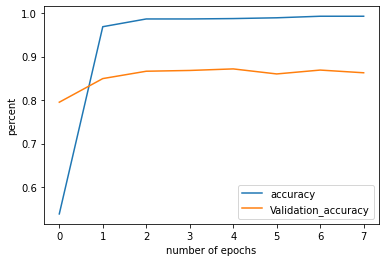

In [ ]:
plt.plot(history.history["top1acc"],label="accuracy")
plt.plot(history.history["val_top1acc"],label="Validation_accuracy")
plt.legend()
plt.xlabel("number of epochs")
plt.ylabel("percent")

Text(0, 0.5, 'percent')

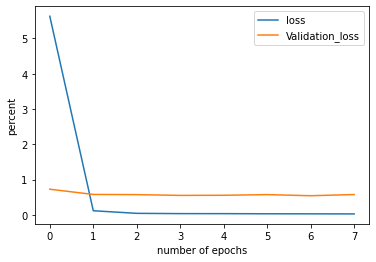

In [ ]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="Validation_loss")
plt.legend()
plt.xlabel("number of epochs")
plt.ylabel("percent")

In [ ]:
con3d_model.evaluate(test_x,test_y)

36/36 [==============================] - 2s 43ms/step - loss: 0.5737 - top5acc: 0.9742 - top1acc: 0.8629


[0.5737271904945374, 0.974176287651062, 0.8628672957420349]